# **DIRECTIONS:** Please Read First

Browser:
* Must use **Chrome** browser (esp not Safari)

Colab:
* Use **GPU Runtime** for Transformer Models

Input Raw Text File:
* Filename Format **(TitleInCamelCase)_(FnameLnameInCamelCase).txt**
* Use only **plain text** files (no *.rtf, *.doc, etc)
* ***Headers/Footers deleted***, only first line to last line of novel text
* ***Paragraphs*** separarted by at least **two blank lines**
* ***Chapters/Sections*** separated by line starting with **'CHAPTER...'** and preceeded/suceeded by at least two blank lines
* Encode in **'utf-8'**

Novels (Get plain text if possible):
* https://gutenberg.net.au/ (AUS)
* https://gutenberg.org/ (US)

Notebook Notation:
* **OPTION (n)** means execute only **ONE** of the OPTIONS provided
* **STEP (n)** means execute **ALL** of the STEPS that follow

# SentimentArcs Simplified Notebook

Created:

* 28 Oct 2022
* Jon Chun

A simplified version of SentimentArcs Notebooks with only the most common and state-of-the-art sentiment analysis models in the ensemble. This operationalizes SentimentArcs more accessible and robust.

* https://github.com/jon-chun/sentimentarcs_notebooks

* https://arxiv.org/pdf/2110.09454.pdf

In [1]:
# Node GPU Count/Type

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-81a2cb4f-c1a8-9aa8-8306-f54f2ef2c82e)


In [2]:
# Memory

!free -h --si | awk  '/Mem:/{print $2}'

13G


# Setup

## Install Libraries

In [3]:
# !pip install transformers[sentencepiece]

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 163 kB 47.3 MB/s 
     |████████████████████████████████| 7.6 MB 54.7 MB/s 


In [4]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.1 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=de14bc4aa1ac7505c9ff521f23751052e21161245ce2d3b0f8a13f31bb316783
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [5]:
!pip install unidecode  # clean-text dependency

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.1 MB/s 


In [6]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.2 MB/s 
     |████████████████████████████████| 287 kB 32.0 MB/s 


In [7]:
# May require [RESET RUNTIME]

# !pip install modin[all]

## Import Libraries

In [8]:
from google.colab import files

In [9]:
import numpy as np
import pandas as pd
# import modin.pandas as pd_modin
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import datetime
import os

from cleantext import clean
import contractions

# from tqdm import tqdm
# import tqdm.notebook as tq


from sklearn.preprocessing import MinMaxScaler, StandardScaler


## Configure Settings

In [10]:
# Setup matplotlib

# %matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Global Variables & Functions

## Global Variables

In [11]:
# Global Vars

novel_filename_str = ''
novel_title_str = ''
novel_raw_str = ''
novel_clean_str = ''

novel_lines_ls = []
novel_sentences_ls = []
novel_paragraphs_ls = []

# Main (Modin) DataFrame for Novel Sentiments
sentiment_df = pd.DataFrame

TEXT_ENCODING = 'utf-8'

## Common Functions

In [12]:
def verify_novel(anovel_raw_str, anovel_title_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Title: {anovel_title_str}')
  print(f'  Char Len: {len(anovel_raw_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {anovel_raw_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {anovel_raw_str[-index_ends:]}\n\n')

In [13]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [14]:
def save_df2csv_and_download(df_obj, novel_name_str, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False) 
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

In [15]:
def expand_contractions(input_str):
  '''
  INPUT: long string
  OUTPUT: long string with expanded contractions
  '''

  output_str = contractions.fix(input_str)

  return output_str

"""
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]
"""

'\n# novel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_ls]\nnovel_clean_ls = [contractions.fix(x) for x in novel_ls]\nnovel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_clean_ls]\nnovel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]\n# novel_clean_ls = [re.sub(r"^["\']", "", x) for x in novel_clean_ls]  # re.sub("["\']", "", s)\n# novel_clean_ls = [re.sub(r"["\']$", "", x) for x in novel_clean_ls]\nnovel_clean_ls = [x.encode(\'ascii\',errors=\'ignore\').decode() for x in novel_clean_ls]\n# novel_bin = novel_clean_str.encode(\'ascii\',errors=\'ignore\')\n# novel_clean_str = novel_bin.decode()\n\n[f\'[{x}]\' for x in novel_clean_ls]\n'

In [16]:
# SKIP to next section

# I. Get Raw Text (Pick ONE Option)

## OPTION (a): Upload Raw Textfile

In [109]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

filename_ext_str = novel_filename_str.split('.')[-1]
if filename_ext_str == 'txt':
  # Extract from Dict and decode binary into char string
  novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)
else:
  print(f'\n\nERROR: Invalid filetype {filename_ext_str}')
  print('===============================================')
  print('\n\nRERUN and UPLOAD only plain textfiles with extension *.txt')

Saving Persuasion_JaneAusten.txt to Persuasion_JaneAusten.txt
User uploaded file "Persuasion_JaneAusten.txt" with length 468799 bytes
CPU times: user 45.2 ms, sys: 16 ms, total: 61.2 ms
Wall time: 4.98 s


In [112]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "Persuasion by Jane Austen" #@param {type:"string"}

novel_title_str = Novel_Title

In [113]:
# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

Novel Filename:

  Persuasion_JaneAusten.txt


Novel Title: Persuasion by Jane Austen
  Char Len: 464212

Beginning:

 Sir Walter Elliot, of Kellynch Hall, in Somersetshire, was a man who, for his own amusement, never took up any book but the Baronetage; there he found occupation for an idle hour, and consolation in a distressed one; there his faculties were roused into admiration and respect, by contemplating the limited remnant of the earliest patents; there any unwelcome sensations, arising from domestic affairs changed naturally into pity and contempt as he turned over the almost endless creations of the las



------------------------------------
Ending:

  as her friend Anne’s was in the warmth of her heart. Anne was tenderness itself, and she had the full worth of it in Captain Wentworth’s affection. His profession was all that could ever make her friends wish that tenderness less, the dread of a future war all that could dim her sunshine. She gloried in being a sailor’s wife, b

**[SKIP] to Section II: Clean Text**

## OPTION (b): Read from gDrive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive

In [ ]:
# drive.mount("/gdrive", force_remount=True)

In [ ]:
# CUSTOMIZE: set GDrive path below

%cd ./MyDrive/courses/2021f_iphs200_programming_humanity/code/

In [ ]:
!ls *.txt

In [ ]:
# CUSOTMIZE: set 'novel_filename' to the filename of your novel

# novel_filename = 'jkrowling_1sorcerersstone.txt'
novel_filename_str ='Percy_Jackson_The_Lightning_Thief.txt'

In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "The Lightening Thief by Percy Jackson" #@param {type:"string"}
novel_title_str = Novel_Title

In [ ]:
# Read file into string

with open(novel_filename_str, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step

In [ ]:
# Verify

# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

In [ ]:
# END

In [ ]:
# Read novel into list of Paragraphs

delimiter = "\n\n"

with open(novel_filename, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step
  #using the string methods we split it
  novel_parags_ls = novel_raw_str.split(delimiter)
  novel_parags_ls = [x.strip() for x in novel_parags_ls if len(x.strip()) > 2]

print(f'Paragraph Count: {len(novel_parags_ls)}')

In [ ]:
# Read novel into list of Lines

# may need delimiter

with open(novel_filename, 'r') as fp:
  novel_lines_ls = fp.readlines()

print(f'Line Count: {len(novel_lines_ls)}')

In [ ]:
novel_parags_ls[:10]

In [ ]:
novel_ls[100:110]

In [ ]:
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]

In [ ]:
novel_clean_str = '\n'.join(novel_clean_ls)
print(novel_clean_str[:5000])

In [ ]:
# novel_clean_ls[1] = "THE SILVER SPOON I was born twice: first, as a baby girl, on a remarkably smogless Detroit day in January of 1960; and then again, as a teenage boy, in an emergency room near Petoskey, Michigan, in August of 1974. Specialized readers may have come across me in Dr. Peter Luce’s study, “Gender Identity in 5-Alpha-Reductase Pseudohermaphrodites,” published in theJournal of Pediatric Endocrinology in 1975. Or maybe you’ve seen my photograph in chapter sixteen of the now sadly outdatedGenetics and Heredity."

In [ ]:
# novel_clean_ls.pop(0)

In [ ]:
novel_clean_ls[:10]

In [ ]:
novel_clean_ls[-10:]

In [ ]:
# novel_clean_str = '\n'.join(novel_clean_ls)

# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

# print(novel_clean_str[:5000])

**[SKIP] to Section II: Clean Text**

## OPTION (c): Scrape Project Gutenberg

**Goto *https://gutenberg.net.au* and find the *.HTML (not *.TXT) version of your novel**

In [ ]:
from bs4 import BeautifulSoup

import requests

In [ ]:
#@title Enter the URL of your novel at ***gutenberg.net.au***
#@markdown Paste the URL to the ***HTML version*** (not plain text).

Novel_Title = 'Frankenstein by Mary Shelley'  #@param {type: "string"}

Gutenberg_URL = 'https://gutenberg.net.au/ebooks/z00006.html'  #@param {type: "string"}


In [ ]:
# Get raw HTML of novel from Gutenberg.net.au

response=requests.get(Gutenberg_URL)  # TODO: Pass the URL to the .get() method of the requests object
html = response.text

In [ ]:
# View raw HTML that we need to clean up

# TODO: What is the difference between these two outputs?

# Option A: 
html

# Option B:
# print(html)

In [ ]:
# Use HTML <p> to extract text into list of paragraphs

soup = BeautifulSoup(html, "html.parser")


paragraph=soup.find_all("p")  # TODO: get all the <P>Paragraphs</P> 
                                #       see bs4 API ref: https://beautiful-soup-4.readthedocs.io/en/latest/#kinds-of-objects
parag_ls = []
for para in paragraph:
    parag_ls.append(para.text)

print(f'There were {len(parag_ls)} Paragraphs:\n') # TODO how do you get the number of paragraphs in the list parag_ls?

print(f"First 3 Paragraphs: ==============================    \n")
print(f"    {list(print(x) for x in parag_ls[:3])}\n")  # TODO: Give index to retrieve the first 3 paragraphs

print(f"Last 3 Paragraphs: ============================== \n")
print(f"    {list(print(x) for x in parag_ls[-3:])}\n")  # TODO: Give index to retrieve the last 3 paragraphs


In [ ]:
# Concatenate all paragraphs into a single novel string

# For every paragraph, replace all hardcoded \r\n with a single space
parag_flat_ls = [re.sub(r'\r\n', ' ', aparag) for aparag in parag_ls]

# Concatenate all paragraphs into a single string, separated by two \n
novel_raw_str = '\n\n'.join(parag_flat_ls)

print('\nSTART OF NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF NOVEL: -----\n')
print(novel_raw_str[-1000:])

**Enter the First and Last several words to use as RegEx for trimming header/footers**

In [ ]:
#@title Enter the first sentence in the body of your novel
sentence_first_str = 'St. Petersburgh, Dec. 11th'  #@param {type: "string"}




In [ ]:
#@title Enter the last sentence in the body of your novel
sentence_last_str = 'waves and lost in darkness and distance.'  #@param {type: "string"}

In [ ]:
# Strip off the header
# novel_clean = ' '.join(novel_str.partition(sentence_first_str)[1:])

# Strip off the footer
# ' '.join(novel_clean.partition(sentence_last_str)[:2])[-500:]

In [ ]:
# Strip off the header
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_first_str)[1:])

# Strip off the footer
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_last_str)[:2])

# Verify

print('\nSTART OF CLEAN NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF CLEAN NOVEL: -----\n')
print(novel_raw_str[-1000:])

**[SKIP] to Section II: Clean Text**

# II. Clean Text (Pick ONE Option)

## OPTION (a): Upload Preprocessed Clean Textfile

In [20]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

filename_ext_str = novel_filename_str.split('.')[-1]
if filename_ext_str == 'csv':
  # Extract from Dict and decode binary into char string
  # novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)
  sentiment_df = pd.read_csv(novel_filename_str) # , index_col=[0])

else:
  print(f'\n\nERROR: Invalid filetype {filename_ext_str}')
  print('===============================================')
  print('\n\nRERUN and UPLOAD only plain textfiles with extension *.txt')

KeyboardInterrupt: ignored

In [21]:
# Verify

novel_camel_str = novel_filename_str.split('_cleaned.csv')[0]

novel_title_str = ' '.join(re.findall('[A-Z][^A-Z]*', novel_camel_str))

print(f'novel_title_str: {novel_title_str}')

sentiment_df.head()
sentiment_df.info()

novel_title_str: Homage to  Catalonia.txt


TypeError: ignored

In [ ]:
# Rebuild Novel raw string

novel_raw_str = ' '.join(sentiment_df['text_raw'].to_list())
novel_clean_str = ' '.join(sentiment_df['text_clean'].to_list())

novel_raw_str[:500]
print('\n')
len(novel_raw_str)


In [ ]:
# Verify

verify_novel(novel_clean_str, novel_title_str, index_ends=500)

**[SKIP] to Section III: Get Sentiments**

## OPTION (b): Clean Raw Text Now

### Segment Text

* https://github.com/zaemyung/sentsplit (CRF: mincut)

* https://github.com/adobe/NLP-Cube and Rank ~15 https://aclanthology.org/K18-2017.pdf

In [114]:
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [115]:
novel_sentences_ls = sent_tokenize(novel_raw_str)

sent_ct = len(novel_sentences_ls)
sent_show = 10

print('\nFirst Sentences: -----\n')
# for i, asent in enumerate(novel_sentences_ls[:sent_show]):
for i, asent in enumerate(novel_sentences_ls[:sent_show]):
  print(f'Sentences #{i}: {asent}')


print('\nLast Sentences: -----\n')
for i, asent in enumerate(novel_sentences_ls[-sent_show:]):
  print(f'Sentences #{sent_ct - (sent_show - i)}: {asent}')


print(f'\n\nThere are {sent_ct} Sentences in the novel')


First Sentences: -----

Sentences #0: Sir Walter Elliot, of Kellynch Hall, in Somersetshire, was a man who, for his own amusement, never took up any book but the Baronetage; there he found occupation for an idle hour, and consolation in a distressed one; there his faculties were roused into admiration and respect, by contemplating the limited remnant of the earliest patents; there any unwelcome sensations, arising from domestic affairs changed naturally into pity and contempt as he turned over the almost endless creations of the last century; and there, if every other leaf were powerless, he could read his own history with an interest which never failed.
Sentences #1: This was the page at which the favourite volume always opened:
“ELLIOT OF KELLYNCH HALL.
Sentences #2: “Walter Elliot, born March 1, 1760, married, July 15, 1784, Elizabeth, daughter of James Stevenson, Esq.
Sentences #3: of South Park, in the county of Gloucester, by which lady (who died 1800) he has issue Elizabeth, bo

In [116]:
# Delete the empty Sentences and those without any alphabetic characters

novel_sentences_ls = [x.strip() for x in novel_sentences_ls if len(x.strip()) > 0]
novel_sentences_ls = [x.strip() for x in novel_sentences_ls if re.search('[a-zA-Z]', x)]
len(novel_sentences_ls)

3140

In [117]:
# View the shortest Setences

sorted(novel_sentences_ls, key=len)[:100]
# type(min(novel_sentences_ls, key=len))
# novel_sentences_ls[:1000]

['Oh!',
 'Oh!',
 'Oh!',
 'Oh!',
 'Ah!',
 'Ah!',
 'Oh!',
 'Oh!',
 'Oh!',
 'Ah!',
 'Oh!',
 'Oh!',
 'no.',
 '“Oh!',
 '“Ah!',
 '“Oh!',
 '“Oh!',
 '“Oh!',
 '“Oh!',
 '“Oh!',
 '“Ha!',
 '“Oh!',
 'yes.',
 'Alas!',
 'What!',
 'Lord!',
 'alas!',
 'dear!',
 '“What!',
 'I went.',
 'How so?',
 '“Oh God!',
 'oh Lord!',
 '“Indeed!',
 'At Lyme.',
 'Bless me!',
 'Bless me!',
 '“Dear me!',
 '“Dear me!',
 'Poor man!',
 'Frederick!',
 'Thank God!',
 'CHAPTER X.',
 '“Very few.',
 'Mrs Smith!',
 'is it you?',
 'for shame!',
 'But, alas!',
 'Next week?',
 'Who is it?',
 'very true.',
 'CHAPTER II.',
 'CHAPTER VI.',
 'CHAPTER IX.',
 'no, indeed!',
 'CHAPTER XI.',
 'CHAPTER XV.',
 'CHAPTER XX.',
 'Why was it?',
 'CHAPTER III.',
 'CHAPTER VII.',
 '“It is over!',
 'Now nothing!',
 'CHAPTER XII.',
 'CHAPTER XIV.',
 'and so late!',
 'CHAPTER XVI.',
 'A Mrs Smith.',
 'I think not.',
 'for himself.',
 'CHAPTER XXI.',
 'I recollect.',
 'My own self.',
 'how very odd!',
 'They had met.',
 '“She is dead!',
 'CHAPTER XIII

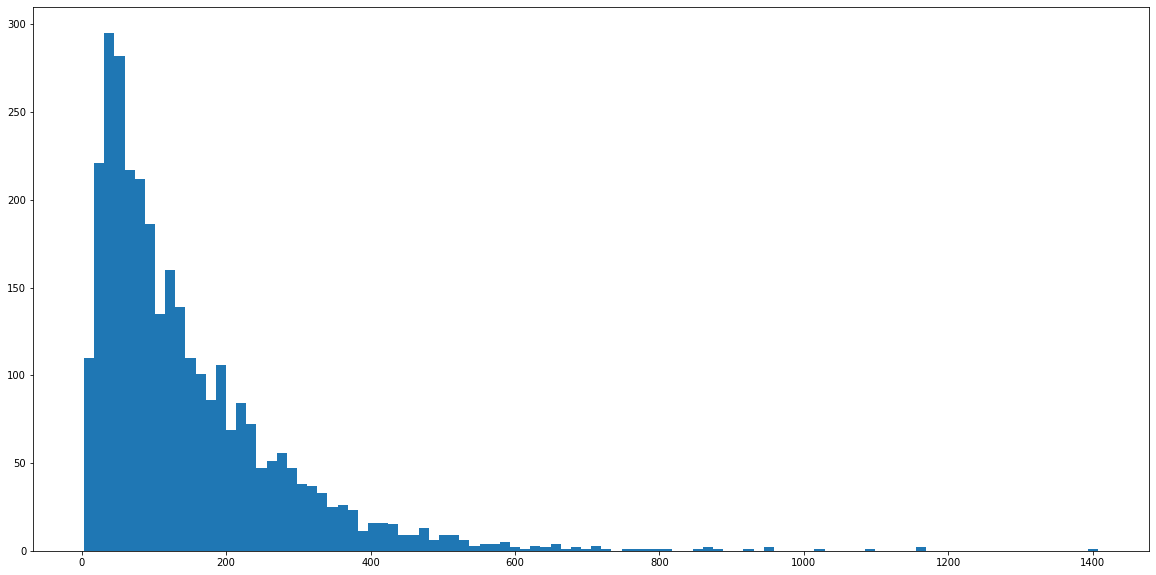

In [118]:
# View distribution of sentence lengths

_ = plt.hist([len(x) for x in novel_sentences_ls], bins=100)

In [119]:
# SKIP to next section

In [120]:
# !pip install pysbd  # Python Sentence Boundry Detection

In [121]:
# import pysbd

In [122]:
%%time

# NOTE: 1m05s

# Split Novel into Segments (~Sentences)
"""
seg = pysbd.Segmenter(language="en", clean=False)
novel_segments_ls = seg.segment(novel_trim_str)
"""

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


'\nseg = pysbd.Segmenter(language="en", clean=False)\nnovel_segments_ls = seg.segment(novel_trim_str)\n'

In [123]:
# Trim any leading/trailing whitespace on all Sentences

# novel_clean_ls = [x.strip() for x in novel_segments_ls]

In [124]:
# Verify

# verify_novel(novel_clean_ls, 10)

In [125]:
# Save to file and download copy

# save_text2txt_and_download(novel_clean_ls, '_segments.txt')

In [126]:
# sentiment_df

In [127]:
# Populate novel sentiment_df with sentence number and clean segmented strings

"""
sentence_no_ls = list(range(len(novel_clean_ls)))
sentence_no_ls[-1]

sentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})
sentiment_df.head()
"""

"\nsentence_no_ls = list(range(len(novel_clean_ls)))\nsentence_no_ls[-1]\n\nsentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})\nsentiment_df.head()\n"

### Clean Strings

In [128]:
def clean_str(dirty_str):
  '''
  INPUT: a raw string
  OUTPUT: a clean string
  '''

  contraction_expanded_str = contractions.fix(dirty_str)

  clean_str = clean(contraction_expanded_str,
      fix_unicode=True,               # fix various unicode errors
      to_ascii=True,                  # transliterate to closest ASCII representation
      lower=True,                     # lowercase text
      no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
      no_urls=False,                  # replace all URLs with a special token
      no_emails=False,                # replace all email addresses with a special token
      no_phone_numbers=False,         # replace all phone numbers with a special token
      no_numbers=False,               # replace all numbers with a special token
      no_digits=False,                # replace all digits with a special token
      no_currency_symbols=False,      # replace all currency symbols with a special token
      no_punct=False,                 # remove punctuations
      # replace_with_punct="",          # instead of removing punctuations you may replace them
      # replace_with_url="<URL>",
      # replace_with_email="<EMAIL>",
      # replace_with_phone_number="<PHONE>",
      # replace_with_number="<NUMBER>",
      # replace_with_digit="0",
      # replace_with_currency_symbol="<CUR>",
      lang="en"                       # set to 'de' for German special handling
  )

  # Replace all new lines/returns with single whitespace
  clean_str = ' '.join(clean_str.split())
  # clean_str = clean_str.replace('\n\r', ' ')
  # clean_str = clean_str.replace('\n', ' ')
  # clean_str = clean_str.replace('\r', ' ')
  # clean_str = ' '.join(clean_str.split())
  return clean_str 

# Test

clean_str("This \n\n\n is a very dirty DIRTY StrInG!!")

'this is a very dirty dirty string!!'

In [129]:
# Verify

# verify_novel(novel_clean_str, index_ends=500)

In [130]:
# Create sentiment_df to hold text sentences and corresponding sentiment values

sentiment_df = pd.DataFrame({'text_raw': novel_sentences_ls})
sentiment_df['text_raw'] = sentiment_df['text_raw'].astype('string')
sentiment_df['text_raw'] = sentiment_df['text_raw'].str.strip()

# clean the 'text_raw' column and create the 'text_clean' column
# novel_df['text_clean'] = hero.clean(novel_df['text_raw'])
sentiment_df['text_clean'] = sentiment_df['text_raw'].apply(lambda x: clean_str(x))
sentiment_df['text_clean'] = sentiment_df['text_clean'].astype('string')
sentiment_df['text_clean'] = sentiment_df['text_clean'].str.strip()
sentiment_df['text_raw_len'] = sentiment_df['text_raw'].apply(lambda x: len(x))
sentiment_df['text_clean_len'] = sentiment_df['text_clean'].apply(lambda x: len(x))

sentiment_df.head()
sentiment_df.info()

,text_raw,text_clean,text_raw_len,text_clean_len
0,"Sir Walter Elliot, of Kellynch Hall, in Somers...","sir walter elliot, of kellynch hall, in somers...",624,624
1,This was the page at which the favourite volum...,this was the page at which the favourite volum...,89,88
2,"“Walter Elliot, born March 1, 1760, married, J...","""walter elliot, born march 1, 1760, married, j...",104,104
3,"of South Park, in the county of Gloucester, by...","of south park, in the county of gloucester, by...",497,497
4,"of Uppercross, in the county of Somerset,” and...","of uppercross, in the county of somerset,"" and...",127,127


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text_raw        3140 non-null   string
 1   text_clean      3140 non-null   string
 2   text_raw_len    3140 non-null   int64 
 3   text_clean_len  3140 non-null   int64 
dtypes: int64(2), string(2)
memory usage: 98.2 KB


In [131]:
# Check for any empty text_clean strings

sentiment_df[sentiment_df['text_clean_len'] == 0]['text_clean']

Series([], Name: text_clean, dtype: string)

In [132]:
# Drop Sentence if Raw length < 1 (Double check)
sentiment_df = sentiment_df[sentiment_df['text_raw_len'] > 0]
sentiment_df.shape

# Fill any empty text_clean with a neutral word
neutral_word = 'NEUTRALWORD'
sentiment_df[sentiment_df['text_clean_len'] == 0]['text_clean'] = neutral_word
sentiment_df[sentiment_df['text_clean_len'] == 0]['text_clean_len'] = 11
sentiment_df['text_clean_len'].sort_values(ascending=True) # , key=lambda x: len(x), inplace=True)
# sentiment_df.text_clean.fillna(value='', inplace=True)

(3140, 4)

866        3
2758       3
532        3
339        3
1947       3
        ... 
144     1016
1039    1096
2503    1160
2888    1165
383     1408
Name: text_clean_len, Length: 3140, dtype: int64

In [133]:
# Add Line Numbers
sentence_no_ls = list(range(sentiment_df.shape[0]))
sentiment_df.insert(0, 'line_no', sentence_no_ls)

In [134]:
# View the shortest lines by text_raw_len

sentiment_df.sort_values(by=['text_raw_len']).head(20)

,line_no,text_raw,text_clean,text_raw_len,text_clean_len
2611,2611,Oh!,oh!,3,3
2758,2758,no.,no.,3,3
1108,1108,Oh!,oh!,3,3
368,368,Oh!,oh!,3,3
759,759,Oh!,oh!,3,3
866,866,Oh!,oh!,3,3
642,642,Ah!,ah!,3,3
532,532,Oh!,oh!,3,3
669,669,Ah!,ah!,3,3
2385,2385,Oh!,oh!,3,3


### Save Cleaned Text

In [135]:
# Save segmented and cleaned text to file

novel_camel_str = ''.join([re.sub(r'[^\w\s]','',x).capitalize() for x in novel_title_str.split()])

save_df2csv_and_download(sentiment_df, novel_camel_str, '_cleaned.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: PersuasionByJaneAusten_cleaned.csv

STEP 2. Downloading permanent copy of csvfile: PersuasionByJaneAusten_cleaned.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**[SKIP] to Section III: Get Sentiments**

# III. Get Sentiments (Pick ONE Option)

## [SKIP] OPTION (a): Upload Preprocessed Sentiment Textfile

In [ ]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

filename_ext_str = novel_filename_str.split('.')[-1]
if filename_ext_str == 'csv':
  # Extract from Dict and decode binary into char string
  # novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)
  sentiment_all_df = pd.read_csv(novel_filename_str) # , index_col=[0])

else:
  print(f'\n\nERROR: Invalid filetype {filename_ext_str}')
  print('===============================================')
  print('\n\nRERUN and UPLOAD only plain textfiles with extension *.txt')


Saving TheGreatGatsbyByFScottFitzgerald_merged.csv to TheGreatGatsbyByFScottFitzgerald_merged (1).csv
User uploaded file "TheGreatGatsbyByFScottFitzgerald_merged.csv" with length 639084 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3443 entries, 0 to 3442
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3443 non-null   int64  
 1   text_raw     3443 non-null   object 
 2   text_clean   3443 non-null   object 
 3   vader        3443 non-null   float64
 4   textblob     3443 non-null   float64
 5   distilbert   3443 non-null   int64  
 6   nlptown      3443 non-null   int64  
 7   roberta15lg  3443 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 215.3+ KB
CPU times: user 353 ms, sys: 50.5 ms, total: 403 ms
Wall time: 33.6 s


In [ ]:
# Verify

sentiment_all_df.head()
sentiment_all_df.info()

,line_no,text_raw,text_clean,vader,textblob,distilbert,nlptown,roberta15lg
0,0,Chapter 1\r\n\r\n\r\n\r\nIn my younger and mor...,chapter 1 in my younger and more vulnerable ye...,-0.2944,0.000000,1,4,1
1,1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",-0.2755,0.000000,0,0,1
2,2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,0.7684,0.500000,1,2,1
3,3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,-0.2732,0.085000,1,1,1
4,4,The abnormal mind\r\nis quick to detect and at...,the abnormal mind is quick to detect and attac...,-0.2960,0.016667,0,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3443 entries, 0 to 3442
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3443 non-null   int64  
 1   text_raw     3443 non-null   object 
 2   text_clean   3443 non-null   object 
 3   vader        3443 non-null   float64
 4   textblob     3443 non-null   float64
 5   distilbert   3443 non-null   int64  
 6   nlptown      3443 non-null   int64  
 7   roberta15lg  3443 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 215.3+ KB


**[SKIP] to Section IV. Plot**

In [ ]:
# SKIP to next section

In [ ]:
model_samelen_ls = [
    'vader',
    'textblob',
    'distilbert',
    'nlptown',
    'roberta15lg',
    # 'syuzhetr'
    ]

model_difflen_ls = [
    'sentimentr'
    ]

In [ ]:
# Hardcoded

filename_root = 'TheGreatGatsbyByFScottFitzgerald'

print('Trying to read VADER Sentiment Datafile...')
try:
  vader_df = df.read_csv(f'{filename_root}_vader.csv')
  print('  Success\n')
except:
  print('  FAILED\n')

print('Trying to read TextBlob Sentiment Datafile...')
try:
  textblob_df = df.read_csv(f'{filename_root}_textblob.csv')
  print('  Success\n')
except:
  print('  FAILED\n')

print('Trying to read DistilBERT Sentiment Datafile...')
try:
  textblob_df = df.read_csv(f'{filename_root}_distilbert.csv')
  print('  Success\n')
except:
  print('  FAILED\n')

print('Trying to read NLPTown Sentiment Datafile...')
try:
  textblob_df = df.read_csv(f'{filename_root}_nlptown.csv')
  print('  Success\n')
except:
  print('  FAILED\n')

print('Trying to read RoBERTa15lg Sentiment Datafile...')
try:
  textblob_df = df.read_csv(f'{filename_root}_roberta15lg.csv')
  print('  Success\n')
except:
  print('  FAILED\n')

"""
for amodel in models_ls:
  afilename = f'{novel_title_str}_{amodel}.csv'
  print(f'Trying to read: {afilename}...')
""";

Trying to read VADER Sentiment Datafile...
  FAILED

Trying to read TextBlob Sentiment Datafile...
  FAILED

Trying to read DistilBERT Sentiment Datafile...
  FAILED

Trying to read NLPTown Sentiment Datafile...
  FAILED

Trying to read RoBERTa15lg Sentiment Datafile...
  FAILED



**[SKIP] to Section IV: Plot**

## OPTION (b): Compute Sentiment Timeseries Now

### STEP (1): Symbolic: Lexicons

#### VADER

In [136]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

In [138]:
sentiment_vader_ls = [sid_obj.polarity_scores(asentence)['compound'] for asentence in sentiment_df['text_clean'].to_list()]

In [139]:
# Create new VADER DataFrame to save results

vader_df = sentiment_df[['line_no', 'text_raw', 'text_clean']].copy(deep=True)
vader_df['sentiment'] = pd.Series(sentiment_vader_ls) 
vader_df.head()

,line_no,text_raw,text_clean,sentiment
0,0,"Sir Walter Elliot, of Kellynch Hall, in Somers...","sir walter elliot, of kellynch hall, in somers...",-0.1814
1,1,This was the page at which the favourite volum...,this was the page at which the favourite volum...,0.0000
2,2,"“Walter Elliot, born March 1, 1760, married, J...","""walter elliot, born march 1, 1760, married, j...",0.0000
3,3,"of South Park, in the county of Gloucester, by...","of south park, in the county of gloucester, by...",0.4310
4,4,"of Uppercross, in the county of Somerset,” and...","of uppercross, in the county of somerset,"" and...",-0.3182


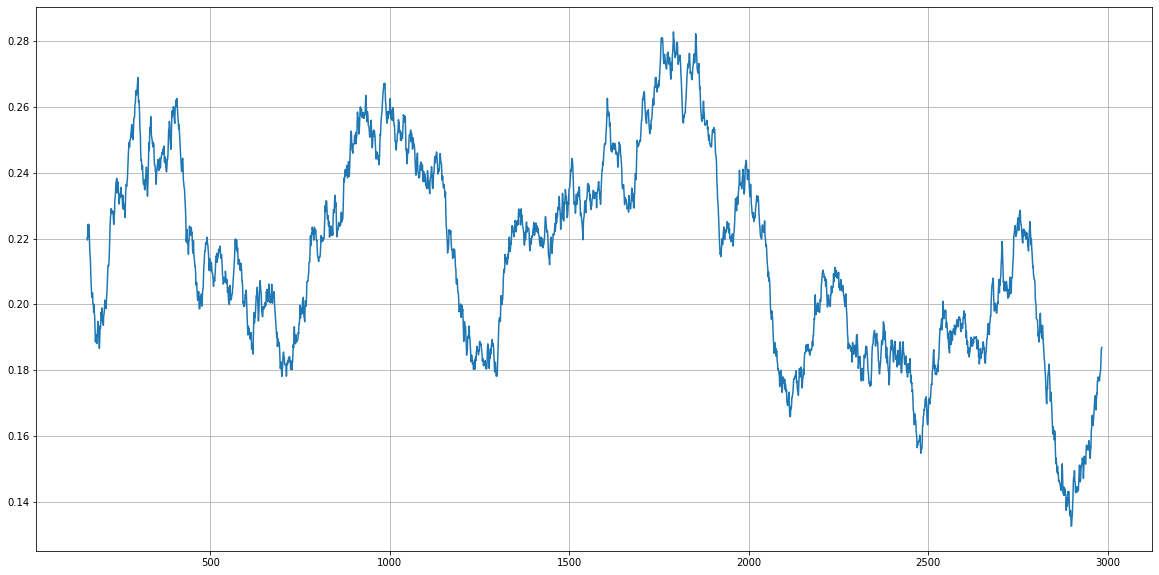

In [140]:
win_per = 0.1
win_size = int(win_per * vader_df.shape[0])

_ = vader_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

In [141]:
# Save Model Sentiment Time Series

novel_camel_str = ''.join([re.sub(r'[^\w\s]','',x).capitalize() for x in novel_title_str.split()])

save_df2csv_and_download(vader_df, novel_camel_str, '_vader.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: PersuasionByJaneAusten_vader.csv

STEP 2. Downloading permanent copy of csvfile: PersuasionByJaneAusten_vader.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### TextBlob

In [142]:
from textblob import TextBlob

In [143]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [144]:
sentiment_textblob_ls = [TextBlob(asentence).sentiment.polarity for asentence in sentiment_df['text_clean'].to_list()]
# sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [145]:
# Create new TextBlob DataFrame to save results

textblob_df = sentiment_df[['line_no', 'text_raw', 'text_clean']].copy(deep=True)
textblob_df['sentiment'] = pd.Series(sentiment_textblob_ls) 
textblob_df.head()

,line_no,text_raw,text_clean,sentiment
0,0,"Sir Walter Elliot, of Kellynch Hall, in Somers...","sir walter elliot, of kellynch hall, in somers...",0.057143
1,1,This was the page at which the favourite volum...,this was the page at which the favourite volum...,0.000000
2,2,"“Walter Elliot, born March 1, 1760, married, J...","""walter elliot, born march 1, 1760, married, j...",0.250000
3,3,"of South Park, in the county of Gloucester, by...","of south park, in the county of gloucester, by...",0.208333
4,4,"of Uppercross, in the county of Somerset,” and...","of uppercross, in the county of somerset,"" and...",0.450000


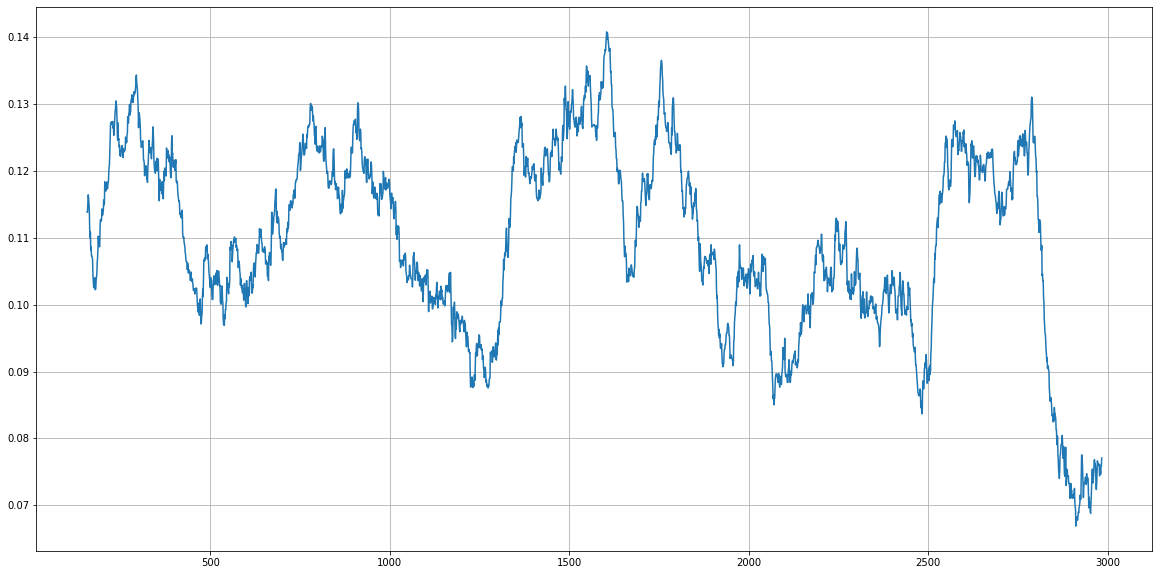

In [146]:
win_per = 0.1
win_size = int(win_per * textblob_df.shape[0])

_ = textblob_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

In [147]:
# Save Model Sentiment Time Series

novel_camel_str = ''.join([re.sub(r'[^\w\s]','',x).capitalize() for x in novel_title_str.split()])

save_df2csv_and_download(textblob_df, novel_camel_str, '_textblob.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: PersuasionByJaneAusten_textblob.csv

STEP 2. Downloading permanent copy of csvfile: PersuasionByJaneAusten_textblob.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### [SKIP] STEP (2): Statistical ML

* https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0

In [ ]:
# Example: Naive Bayes

# https://www.datacamp.com/tutorial/simplifying-sentiment-analysis-python

In [ ]:
# Example: SVM

# https://www.kaggle.com/code/bansodesandeep/sentiment-analysis-support-vector-machine

### STEP (3): Connectionist: Transformers



In [148]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoModelWithLMHead

from transformers import BertTokenizer, BertForSequenceClassification

# import sentencepiece

In [149]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

#### Default DistilBERT

distilbert-base-uncased-finetuned-sst-2-english

* https://huggingface.co/docs/transformers/task_summary

In [150]:
%%time

# NOTE:  1m21s 20:30EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased-finetuned-sst-2-english/snapshots/324d3097568e82724d53d7ac1d312aa719d48037/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache

CPU times: user 1.02 s, sys: 354 ms, total: 1.37 s
Wall time: 2.23 s


In [151]:
# Test

# Test
line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

# Run predictions
predictions = trainer.predict(pred_dataset)

# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

# Create DataFrame with texts, predictions, labels, and scores
line_no_ls = list(range(len(sentiment_ls)))
distilbert_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','sentiment','label','score'])
distilbert_df.head()


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


,line_no,line,sentiment,label,score
0,0,I like that,1,POSITIVE,0.999856
1,1,That is annoying,0,NEGATIVE,0.999752
2,2,This is great!,1,POSITIVE,0.999870
3,3,Wouldn´t recommend it.,1,POSITIVE,0.950235


In [152]:
%%time

# NOTE: 0m15s 14:44PM-EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Compute Sentiment Time Series

line_ls = sentiment_df['text_clean'].to_list()

# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

# Run predictions
predictions = trainer.predict(pred_dataset)

# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

# Create DataFrame with texts, predictions, labels, and scores
line_no_ls = list(range(len(sentiment_ls)))
distilbert_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','sentiment','label','score'])
distilbert_df.head()

***** Running Prediction *****
  Num examples = 3140
  Batch size = 8


CPU times: user 18.4 s, sys: 160 ms, total: 18.6 s
Wall time: 29.8 s


,line_no,line,sentiment,label,score
0,0,"sir walter elliot, of kellynch hall, in somers...",1,POSITIVE,0.982435
1,1,this was the page at which the favourite volum...,1,POSITIVE,0.992513
2,2,"""walter elliot, born march 1, 1760, married, j...",1,POSITIVE,0.974992
3,3,"of south park, in the county of gloucester, by...",0,NEGATIVE,0.862789
4,4,"of uppercross, in the county of somerset,"" and...",0,NEGATIVE,0.786952


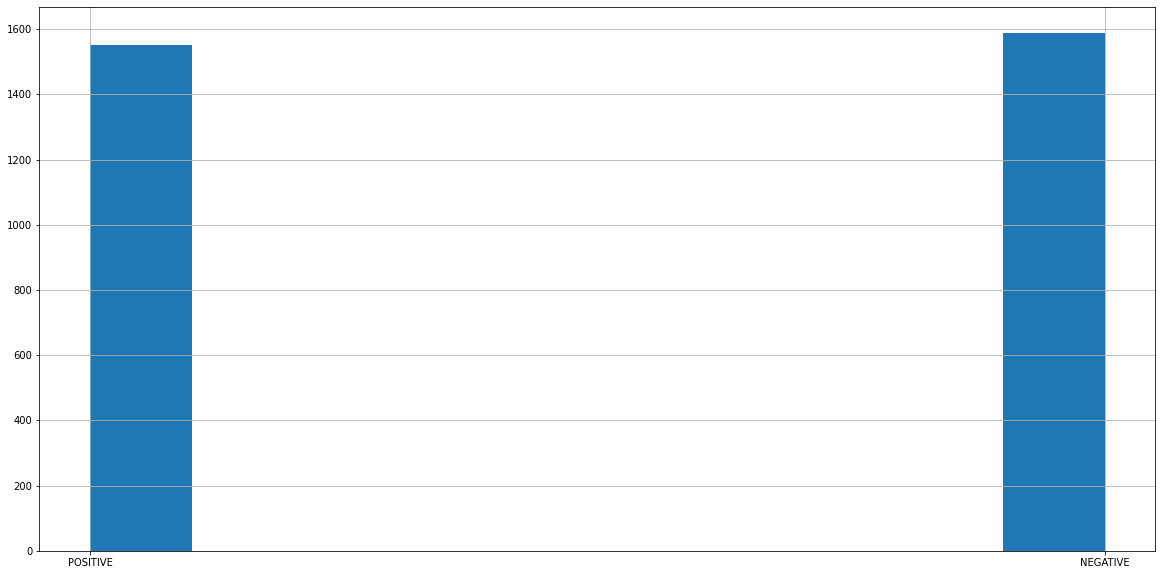

In [153]:
# Ensure balance of sentiments

# distilbert_df['distilbert'].unique()
_ = distilbert_df['label'].hist()

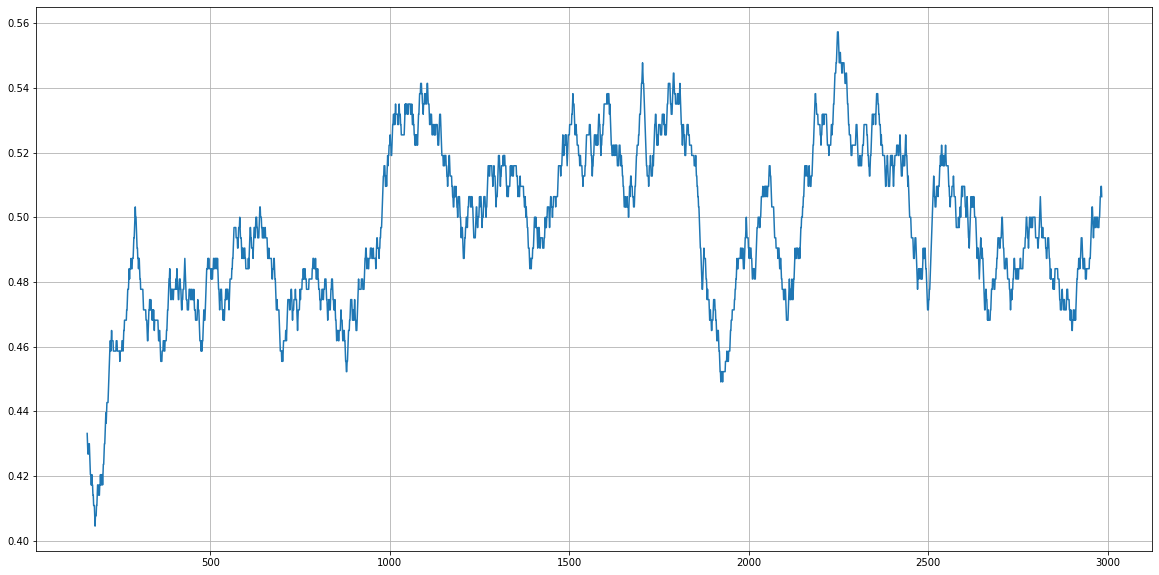

In [154]:
# Plot

win_per = 0.1
win_size = int(win_per * distilbert_df.shape[0])

_ = distilbert_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)


In [155]:
# Save segmented and cleaned text to file

novel_camel_str = ''.join([re.sub(r'[^\w\s]','',x).capitalize() for x in novel_title_str.split()])

save_df2csv_and_download(distilbert_df, novel_camel_str, '_distilbert.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: PersuasionByJaneAusten_distilbert.csv

STEP 2. Downloading permanent copy of csvfile: PersuasionByJaneAusten_distilbert.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### MultiBERT NLPTown

nlptown/bert-base-multilingual-uncased-sentiment

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you

In [156]:
%%time

# NOTE:  1m21s 20:30EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Load tokenizer and model, create trainer

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/e06857fdb0325a7798a8fc361b417dfeec3a3b98/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  

CPU times: user 2.45 s, sys: 1.11 s, total: 3.56 s
Wall time: 5.51 s


In [157]:
# Test
line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

# Run predictions
predictions = trainer.predict(pred_dataset)

# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

# Create DataFrame with texts, predictions, labels, and scores
line_no_ls = list(range(len(sentiment_ls)))
nlptown_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','sentiment','label','score'])
nlptown_df.head()
nlptown_df.info()


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


,line_no,line,sentiment,label,score
0,0,I like that,3,4 stars,0.454108
1,1,That is annoying,2,3 stars,0.417581
2,2,This is great!,4,5 stars,0.833295
3,3,Wouldn´t recommend it.,3,4 stars,0.444085


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   line_no    4 non-null      int64  
 1   line       4 non-null      object 
 2   sentiment  4 non-null      int64  
 3   label      4 non-null      object 
 4   score      4 non-null      float32
dtypes: float32(1), int64(2), object(2)
memory usage: 272.0+ bytes


In [158]:
%%time

# NOTE:  0m25s at 14:51EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Real

line_ls = sentiment_df['text_raw'].to_list()

# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

# Run predictions
predictions = trainer.predict(pred_dataset)

# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

# Create DataFrame with texts, predictions, labels, and scores
line_no_ls = list(range(len(sentiment_ls)))
nlptown_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','sentiment','label','score'])
nlptown_df.head()
nlptown_df.info()

***** Running Prediction *****
  Num examples = 3140
  Batch size = 8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   line_no    3140 non-null   int64  
 1   line       3140 non-null   object 
 2   sentiment  3140 non-null   int64  
 3   label      3140 non-null   object 
 4   score      3140 non-null   float32
dtypes: float32(1), int64(2), object(2)
memory usage: 110.5+ KB
CPU times: user 1min 7s, sys: 358 ms, total: 1min 8s
Wall time: 1min 11s


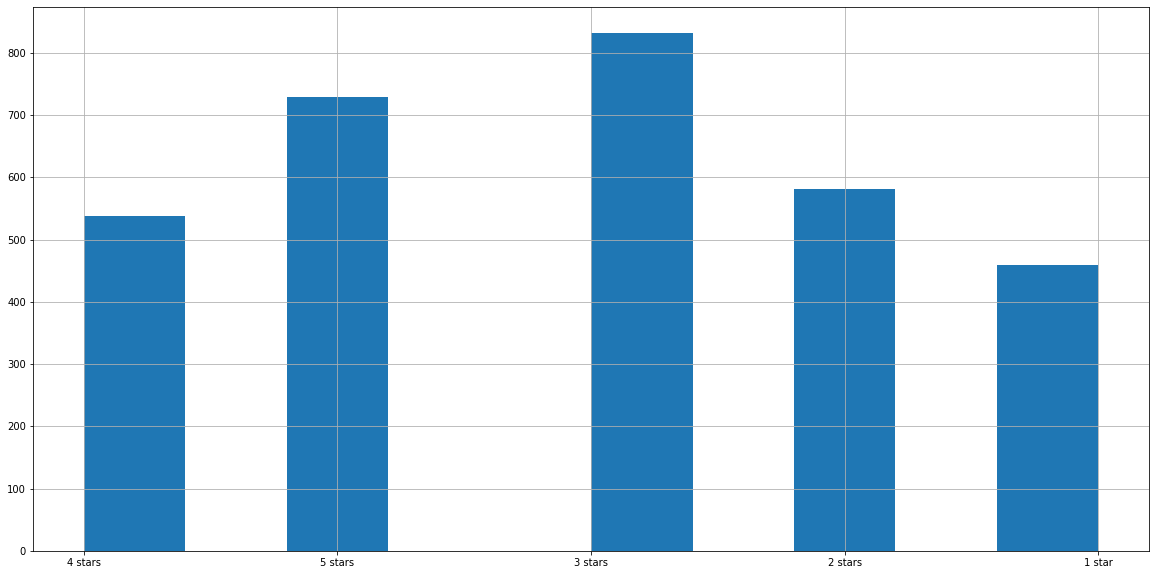

In [159]:
# Ensure balance of sentiments

# nlptown_df['nlptown'].unique()
_ = nlptown_df['label'].hist()

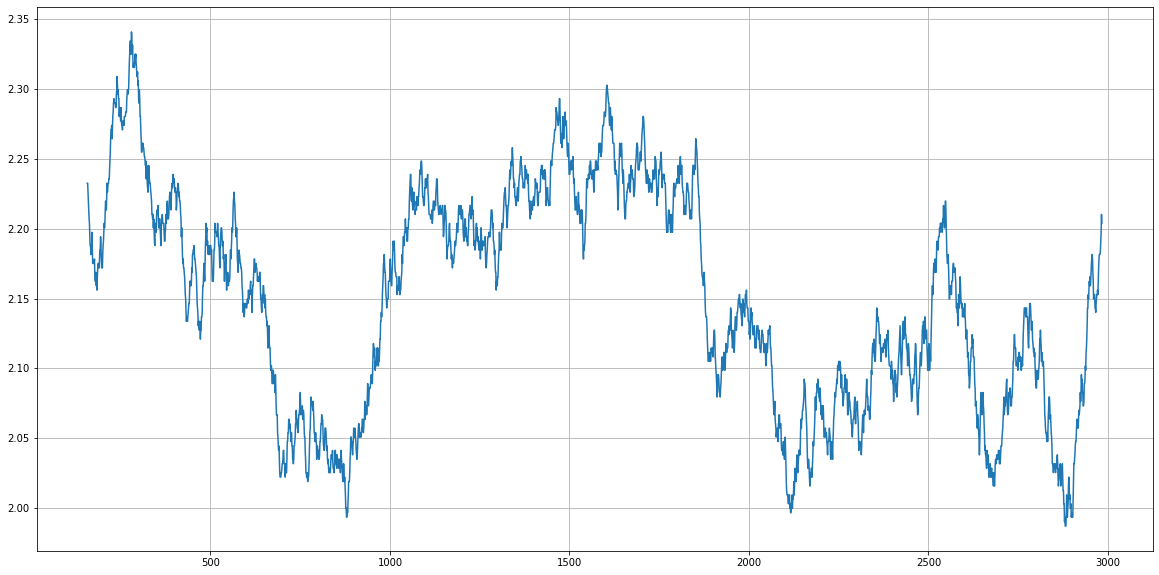

In [160]:
# Plot

win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

_ = nlptown_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)


In [161]:
# Save segmented and cleaned text to file

novel_camel_str = ''.join([re.sub(r'[^\w\s]','',x).capitalize() for x in novel_title_str.split()])

save_df2csv_and_download(nlptown_df, novel_camel_str, '_nlptown.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: PersuasionByJaneAusten_nlptown.csv

STEP 2. Downloading permanent copy of csvfile: PersuasionByJaneAusten_nlptown.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### RoBERTa Lg 15 Datasets

siebert/sentiment-roberta-large-english

* https://colab.research.google.com/github/chrsiebert/sentiment-roberta-large-english/blob/main/sentiment_roberta_prediction_example.ipynb

In [162]:
%%time

# NOTE:  1m21s 20:30EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Load tokenizer and model, create trainer

model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--siebert--sentiment-roberta-large-english/snapshots/6eac71655a474ee4d6d0eee7fa532300c537856d/config.json
Model config RobertaConfig {
  "_name_or_path": "siebert/sentiment-roberta-large-english",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type

CPU times: user 3.4 s, sys: 2.09 s, total: 5.48 s
Wall time: 6.2 s


In [163]:
# Test
line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

# Run predictions
predictions = trainer.predict(pred_dataset)

# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

print(f'labels_ls:\n  {labels_ls}')
print(f'scores_ls:\n {scores_ls}')

***** Running Prediction *****
  Num examples = 4
  Batch size = 8


labels_ls:
  0    POSITIVE
1    NEGATIVE
2    POSITIVE
3    NEGATIVE
dtype: object
scores_ls:
 [0.9986568  0.999409   0.9987269  0.99948555]


In [164]:
%%time

# NOTE:  1m38s 14:00EST on 01 Nov 2022 Colab Pro (The Great Gatsby)
#        1m39s 17:05EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Compute sentiment time series

line_ls = sentiment_df['text_clean'].to_list()

# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

# Run predictions
predictions = trainer.predict(pred_dataset)

# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

print(f'labels_ls:\n  {labels_ls}')
print(f'scores_ls:\n {scores_ls}')

***** Running Prediction *****
  Num examples = 3140
  Batch size = 8


labels_ls:
  0       POSITIVE
1       POSITIVE
2       POSITIVE
3       POSITIVE
4       POSITIVE
          ...   
3135    POSITIVE
3136    POSITIVE
3137    POSITIVE
3138    POSITIVE
3139    POSITIVE
Length: 3140, dtype: object
scores_ls:
 [0.9986167  0.99837106 0.99318707 ... 0.9987597  0.9986816  0.8793485 ]
CPU times: user 3min 4s, sys: 445 ms, total: 3min 5s
Wall time: 3min 7s


In [165]:
# Create DataFrame with texts, predictions, labels, and scores

# sentiment_int_ls = [1 if x.lower().strip() == 'positive' else 0 for x in sentiment_ls.labels.to_list()]
line_no_ls = list(range(len(sentiment_ls)))
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','sentiment','label','score'])
roberta15lg_df.head()
roberta15lg_df.info()

,line_no,line,sentiment,label,score
0,0,"sir walter elliot, of kellynch hall, in somers...",1,POSITIVE,0.998617
1,1,this was the page at which the favourite volum...,1,POSITIVE,0.998371
2,2,"""walter elliot, born march 1, 1760, married, j...",1,POSITIVE,0.993187
3,3,"of south park, in the county of gloucester, by...",1,POSITIVE,0.993307
4,4,"of uppercross, in the county of somerset,"" and...",1,POSITIVE,0.996652


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   line_no    3140 non-null   int64  
 1   line       3140 non-null   object 
 2   sentiment  3140 non-null   int64  
 3   label      3140 non-null   object 
 4   score      3140 non-null   float32
dtypes: float32(1), int64(2), object(2)
memory usage: 110.5+ KB


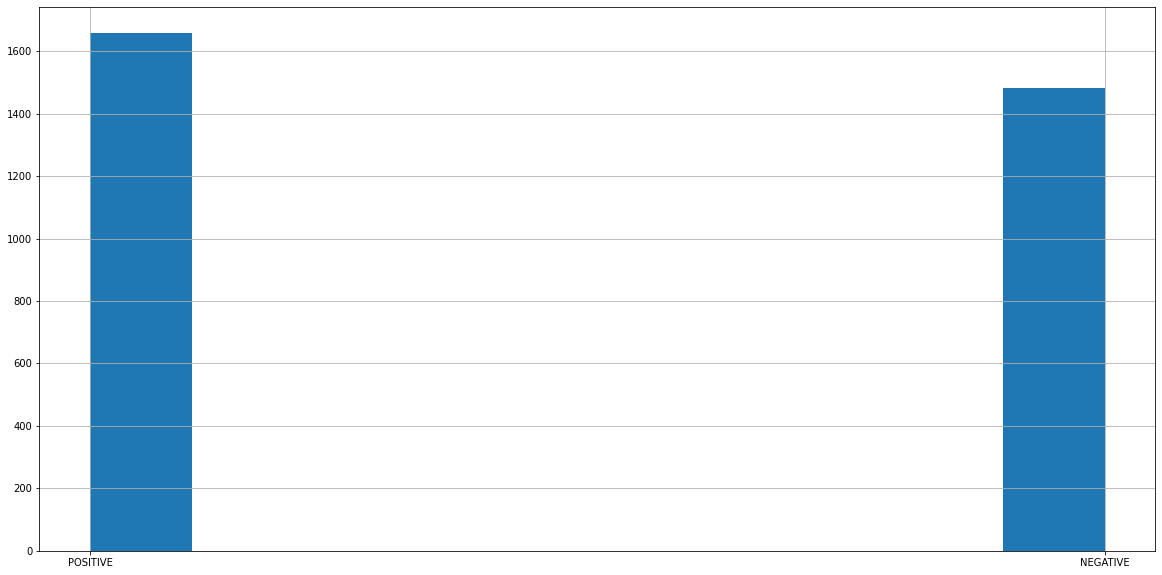

In [166]:
# Ensure balance of sentiments

# roberta15lg_df['roberta15lg'].unique()
_ = roberta15lg_df['label'].hist()

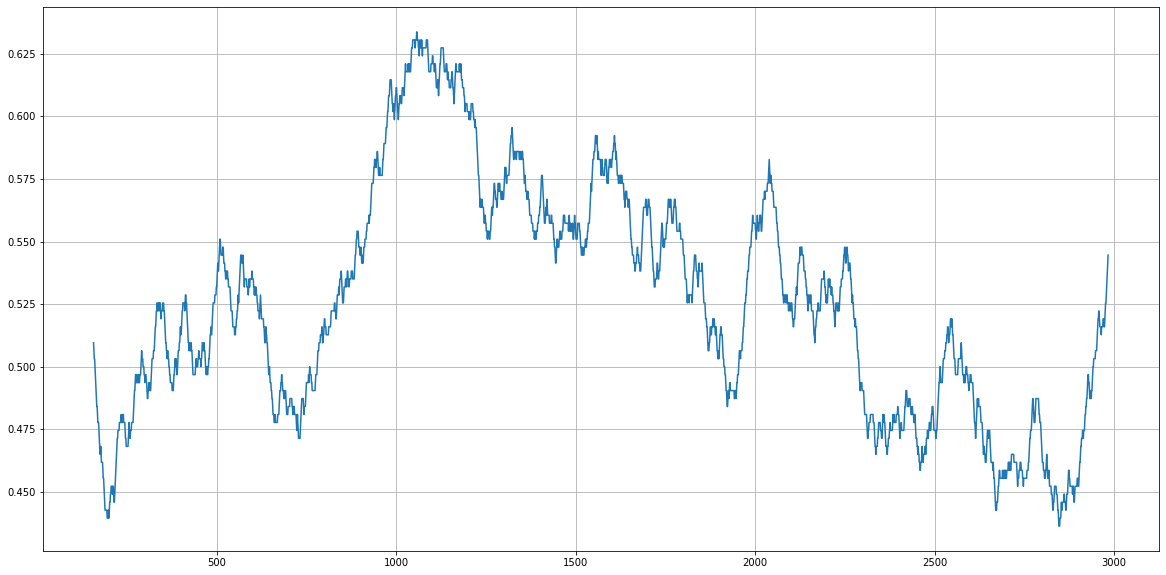

In [167]:
# Plot

win_per = 0.1
win_size = int(win_per * roberta15lg_df.shape[0])

_ = roberta15lg_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)


In [168]:
# Save segmented and cleaned text to file

novel_camel_str = ''.join([re.sub(r'[^\w\s]','',x).capitalize() for x in novel_title_str.split()])

save_df2csv_and_download(roberta15lg_df, novel_camel_str, '_roberta15lg.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: PersuasionByJaneAusten_roberta15lg.csv

STEP 2. Downloading permanent copy of csvfile: PersuasionByJaneAusten_roberta15lg.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### STEP (4): Merge All Models

* VADER
* TextBlob
* SyuzhetR (4)
* DistilBERT
* NLPTown
* RoBERTa15lg

In [169]:
%whos DataFrame

Variable                   Type         Data/Info
-------------------------------------------------
distilbert_df              DataFrame          line_no            <...>\n[3140 rows x 5 columns]
nlptown_df                 DataFrame          line_no            <...>\n[3140 rows x 5 columns]
one_model_df               DataFrame             roberta15lg\nlin<...>\n[4190 rows x 1 columns]
roberta15lg_df             DataFrame          line_no            <...>\n[3140 rows x 5 columns]
sentiment_all_adjnorm_df   DataFrame          line_no            <...>\n[4190 rows x 8 columns]
sentiment_all_df           DataFrame          line_no            <...>\n[4190 rows x 8 columns]
sentiment_all_norm_df      DataFrame          line_no            <...>\n[4190 rows x 8 columns]
sentiment_all_sma_df       DataFrame          line_no            <...>\n[4190 rows x 8 columns]
sentiment_df               DataFrame          line_no            <...>\n[3140 rows x 5 columns]
textblob_df                DataFrame

In [170]:
vader_df.head()

,line_no,text_raw,text_clean,sentiment
0,0,"Sir Walter Elliot, of Kellynch Hall, in Somers...","sir walter elliot, of kellynch hall, in somers...",-0.1814
1,1,This was the page at which the favourite volum...,this was the page at which the favourite volum...,0.0000
2,2,"“Walter Elliot, born March 1, 1760, married, J...","""walter elliot, born march 1, 1760, married, j...",0.0000
3,3,"of South Park, in the county of Gloucester, by...","of south park, in the county of gloucester, by...",0.4310
4,4,"of Uppercross, in the county of Somerset,” and...","of uppercross, in the county of somerset,"" and...",-0.3182


In [171]:
# Merge all dataframes

sentiment_all_df = sentiment_df[['line_no','text_raw','text_clean']].copy(deep=True)

print('Try to merge VADER...')
try:
  sentiment_all_df['vader'] = vader_df['sentiment']
  print('  Success\n')
except:
  print('  FAILED\n')

print('Try to merge TextBlob...')
try:
  sentiment_all_df['textblob'] = textblob_df['sentiment']
  print('  Success\n')
except:
  print('  FAILED\n')

print('Try to merge DistilBERT...')
try:
  sentiment_all_df['distilbert'] = distilbert_df['sentiment']
  print('  Success\n')
except:
  print('  FAILED\n')

print('Try to merge NLPTown...')
try:
  sentiment_all_df['nlptown'] = nlptown_df['sentiment']
  print('  Success\n')
except:
  print('  FAILED\n')

print('Try to merge RoBERTa15lg...')
try:
  sentiment_all_df['roberta15lg'] = roberta15lg_df['sentiment']
  print('  Success\n')
except:
  print('  FAILED\n')

# Verify

sentiment_all_df.head()
sentiment_all_df.info()



Try to merge VADER...
  Success

Try to merge TextBlob...
  Success

Try to merge DistilBERT...
  Success

Try to merge NLPTown...
  Success

Try to merge RoBERTa15lg...
  Success



,line_no,text_raw,text_clean,vader,textblob,distilbert,nlptown,roberta15lg
0,0,"Sir Walter Elliot, of Kellynch Hall, in Somers...","sir walter elliot, of kellynch hall, in somers...",-0.1814,0.057143,1,3,1
1,1,This was the page at which the favourite volum...,this was the page at which the favourite volum...,0.0000,0.000000,1,4,1
2,2,"“Walter Elliot, born March 1, 1760, married, J...","""walter elliot, born march 1, 1760, married, j...",0.0000,0.250000,1,4,1
3,3,"of South Park, in the county of Gloucester, by...","of south park, in the county of gloucester, by...",0.4310,0.208333,0,3,1
4,4,"of Uppercross, in the county of Somerset,” and...","of uppercross, in the county of somerset,"" and...",-0.3182,0.450000,0,4,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3139
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3140 non-null   int64  
 1   text_raw     3140 non-null   string 
 2   text_clean   3140 non-null   string 
 3   vader        3140 non-null   float64
 4   textblob     3140 non-null   float64
 5   distilbert   3140 non-null   int64  
 6   nlptown      3140 non-null   int64  
 7   roberta15lg  3140 non-null   int64  
dtypes: float64(2), int64(4), string(2)
memory usage: 220.8 KB


In [172]:
# Save Sentiment Timeseries to Datafile

novel_camel_str = ''.join([re.sub(r'[^\w\s]','',x).capitalize() for x in novel_title_str.split()])

save_df2csv_and_download(sentiment_all_df, novel_camel_str, '_merged.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: PersuasionByJaneAusten_merged.csv

STEP 2. Downloading permanent copy of csvfile: PersuasionByJaneAusten_merged.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [173]:
model_samelen_ls = [
    'vader',
    'textblob',
    'distilbert',
    'nlptown',
    'roberta15lg',
    # 'syuzhetr'
    ]

model_difflen_ls = [
    'sentimentr'
    ]

In [174]:
# SKIP

In [175]:
print(f'\nThere are {len(model_samelen_ls)} models with same timeseries lengths')
print('----------------------------------------------------------------------------')
model_samelen_csv_ls = [f'{novel_camel_str}_{x}.csv' for x in model_samelen_ls]
model_samelen_csv_ls
print('\n')

print(f'\nThere are {len(model_difflen_ls)} models with different timeseries lengths')
print('----------------------------------------------------------------------------')
model_difflen_csv_ls = [f'{novel_camel_str}_{x}.csv' for x in model_difflen_ls]
model_difflen_csv_ls


There are 5 models with same timeseries lengths
----------------------------------------------------------------------------


['PersuasionByJaneAusten_vader.csv',
 'PersuasionByJaneAusten_textblob.csv',
 'PersuasionByJaneAusten_distilbert.csv',
 'PersuasionByJaneAusten_nlptown.csv',
 'PersuasionByJaneAusten_roberta15lg.csv']




There are 1 models with different timeseries lengths
----------------------------------------------------------------------------


['PersuasionByJaneAusten_sentimentr.csv']

In [176]:
# Merge all same length sentiment time series datafiles

# NOTE: Requires each non-SentimentR datafile have the following format
#       1. line_no:int
#       2. line:str
#       3. sentiment:float
#       4. (option A) label:str
#       5. (option A) score:float
#
#  line (and label/score if present together) are removed before horizontal join on line_no

sentiment_all_df = pd.read_csv(model_samelen_csv_ls[0]) # , index_col=[0])
sentiment_all_df.rename({'sentiment':model_samelen_ls[0]}, axis=1, inplace=True)
# sentiment_all_df.head()

for i, amodel in enumerate(model_samelen_csv_ls[1:]):
  model_name_str = amodel.split('.')[0].split('_')[-1].lower().strip()
  # print(f'Model #{i}: {model_name_str}')
  # print(f'      File: {amodel}')
  one_model_df = pd.read_csv(amodel, index_col=[0])
  # print(f'      Cols: {one_model_df.columns.to_list()}')

  try:
    one_model_df.drop(columns=['line'], inplace=True)
  except:
    pass

  try:
    one_model_df.drop(columns=['label','score'], inplace=True)
  except:
    pass

  one_model_df.rename({'sentiment':model_name_str}, axis=1, inplace=True)
  # one_model_df.head(1)
  sentiment_all_df = sentiment_all_df.merge(one_model_df, on='line_no')

try:
  sentiment_all_df.rename({'text_raw_x':'text_raw', 'text_clean_x':'text_clean'}, axis=1, inplace=True)
except:
  pass

try:
  sentiment_all_df.drop(columns=['text_clean_y', 'text_raw_y'], inplace=True)
except:
  pass

sentiment_all_df.text_raw = sentiment_all_df.text_raw.astype('string')
sentiment_all_df.text_clean = sentiment_all_df.text_clean.astype('string')

sentiment_all_df.head()
sentiment_all_df.info()

,line_no,text_raw,text_clean,vader,textblob,distilbert,nlptown,roberta15lg
0,0,"Sir Walter Elliot, of Kellynch Hall, in Somers...","sir walter elliot, of kellynch hall, in somers...",-0.1814,0.057143,1,3,1
1,1,This was the page at which the favourite volum...,this was the page at which the favourite volum...,0.0000,0.000000,1,4,1
2,2,"“Walter Elliot, born March 1, 1760, married, J...","""walter elliot, born march 1, 1760, married, j...",0.0000,0.250000,1,4,1
3,3,"of South Park, in the county of Gloucester, by...","of south park, in the county of gloucester, by...",0.4310,0.208333,0,3,1
4,4,"of Uppercross, in the county of Somerset,” and...","of uppercross, in the county of somerset,"" and...",-0.3182,0.450000,0,4,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3139
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3140 non-null   int64  
 1   text_raw     3140 non-null   string 
 2   text_clean   3140 non-null   string 
 3   vader        3140 non-null   float64
 4   textblob     3140 non-null   float64
 5   distilbert   3140 non-null   int64  
 6   nlptown      3140 non-null   int64  
 7   roberta15lg  3140 non-null   int64  
dtypes: float64(2), int64(4), string(2)
memory usage: 220.8 KB


**[SKIP] to Section IV: Plot**

# IV. Visualizations

In [85]:
##@title Enter the Sliding Window width as Percent of Novel length (default 10%, larger=smoother)

Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = Window_Percent
win_size = int(win_per/100 * sentiment_all_df.shape[0])

## Plots

### Plot Raw Timeseries

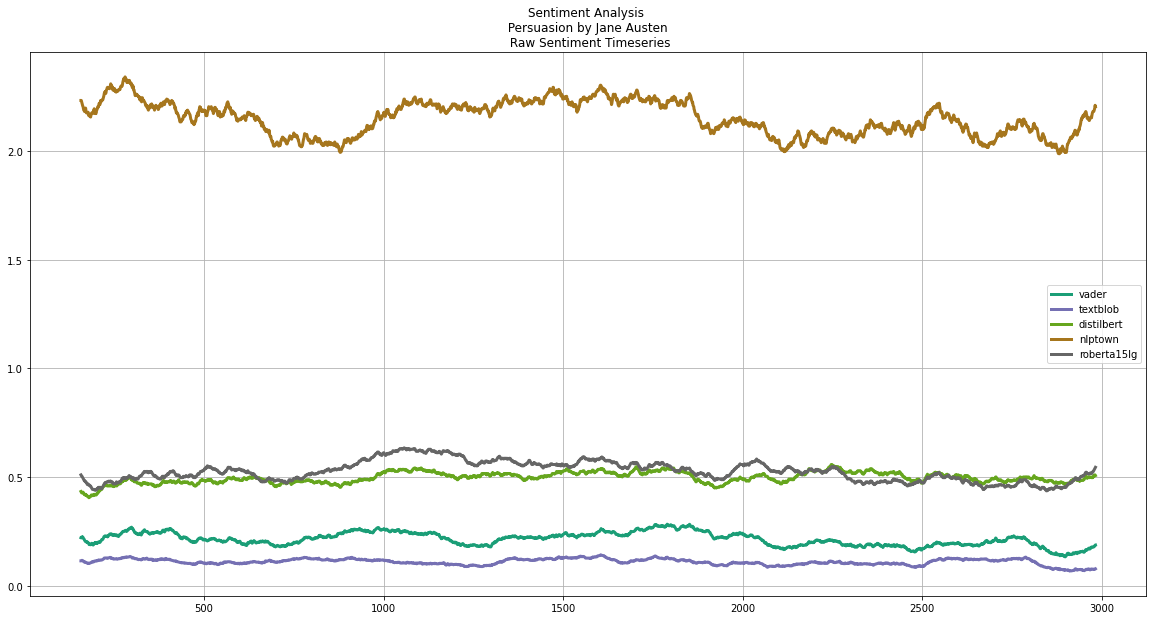

In [177]:
# Plot Raw Timeseries

ax = sentiment_all_df[model_samelen_ls].rolling(win_size, center=True).mean().plot(grid=True, lw=3, colormap='Dark2')
ax.title.set_text(f'Sentiment Analysis \n {novel_title_str} \n Raw Sentiment Timeseries')

plt.show()

### Plot StandardScaler Normalized

In [178]:
# Compute the mean of each raw Sentiment Timeseries and adjust to [-1.0, 1.0] Range

model_samelen_adj_mean_dt = {}

for amodel in model_samelen_ls:
  amodel_min = sentiment_all_df[amodel].min()
  amodel_max = sentiment_all_df[amodel].max()
  amodel_range = amodel_max - amodel_min
  amodel_raw_mean = sentiment_all_df[amodel].mean()
  
  if amodel_range > 2.0:
    model_samelen_adj_mean_dt[amodel] = (amodel_raw_mean + amodel_min)/(amodel_max - amodel_min)*2 + -1.0
  elif amodel_range < 1.1:
    model_samelen_adj_mean_dt[amodel] = (amodel_raw_mean + amodel_min)/(amodel_max - amodel_min)*2 + -1.0
  else:
    model_samelen_adj_mean_dt[amodel] = amodel_raw_mean

  print(f'Model: {amodel}\n  Raw Mean: {amodel_raw_mean}\n  Adj Mean: {model_samelen_adj_mean_dt[amodel]}\n  Min: {amodel_min}\n  Max: {amodel_max}\n  Range: {amodel_range}\n')

Model: vader
  Raw Mean: 0.2148958280254777
  Adj Mean: 0.2148958280254777
  Min: -0.9515
  Max: 0.9921
  Range: 1.9436

Model: textblob
  Raw Mean: 0.10839287768436734
  Adj Mean: 0.10839287768436734
  Min: -1.0
  Max: 1.0
  Range: 2.0

Model: distilbert
  Raw Mean: 0.4942675159235669
  Adj Mean: -0.01146496815286624
  Min: 0
  Max: 1
  Range: 1

Model: nlptown
  Raw Mean: 2.1589171974522294
  Adj Mean: 0.07945859872611472
  Min: 0
  Max: 4
  Range: 4

Model: roberta15lg
  Raw Mean: 0.5280254777070064
  Adj Mean: 0.056050955414012726
  Min: 0
  Max: 1
  Range: 1



In [179]:
# Normalize Timeseries with StandardScaler (u=0, sd=+/- 1)

# sentiment_all_norm_df = pd.DataFrame()
sentiment_all_norm_df = sentiment_all_df[['line_no','text_raw','text_clean']].copy(deep=True)
sentiment_all_norm_df[model_samelen_ls] = StandardScaler().fit_transform(sentiment_all_df[model_samelen_ls])
sentiment_all_norm_df.head()


,line_no,text_raw,text_clean,vader,textblob,distilbert,nlptown,roberta15lg
0,0,"Sir Walter Elliot, of Kellynch Hall, in Somers...","sir walter elliot, of kellynch hall, in somers...",-0.860434,-0.194882,1.011531,0.619085,0.945435
1,1,This was the page at which the favourite volum...,this was the page at which the favourite volum...,-0.466580,-0.412173,1.011531,1.355143,0.945435
2,2,"“Walter Elliot, born March 1, 1760, married, J...","""walter elliot, born march 1, 1760, married, j...",-0.466580,0.538472,1.011531,1.355143,0.945435
3,3,"of South Park, in the county of Gloucester, by...","of south park, in the county of gloucester, by...",0.469203,0.380032,-0.988600,0.619085,0.945435
4,4,"of Uppercross, in the county of Somerset,” and...","of uppercross, in the county of somerset,"" and...",-1.157453,1.298988,-0.988600,1.355143,0.945435


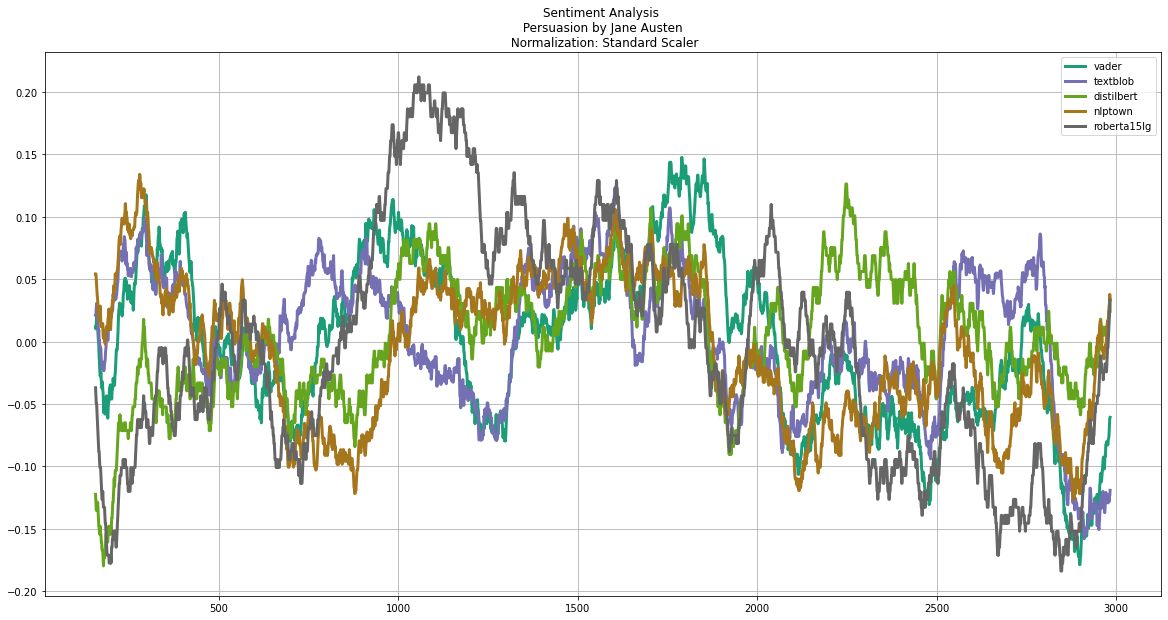

In [180]:
# Plot Normalized Timeseries to same mean

ax = sentiment_all_norm_df[model_samelen_ls].rolling(win_size, center=True).mean().plot(grid=True, colormap='Dark2', lw=3)
ax.title.set_text(f'Sentiment Analysis \n {novel_title_str} \n Normalization: Standard Scaler')

plt.show();


In [181]:
# Save segmented and cleaned text to file

novel_camel_str = ''.join([re.sub(r'[^\w\s]','',x).capitalize() for x in novel_title_str.split()])

save_df2csv_and_download(sentiment_all_norm_df, novel_camel_str, '_allstdscaler.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: PersuasionByJaneAusten_allstdscaler.csv

STEP 2. Downloading permanent copy of csvfile: PersuasionByJaneAusten_allstdscaler.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plot StandardScaler + Original Mean

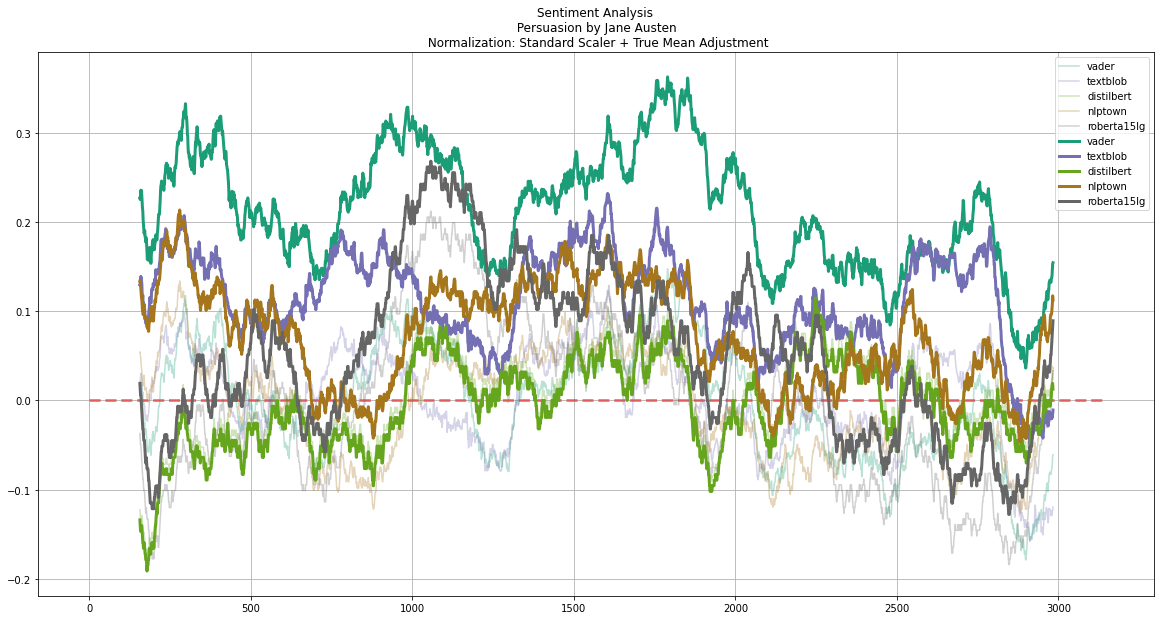

In [182]:
# Plot Normalized Timeseries to adjusted original mean

sentiment_all_adjnorm_df = sentiment_all_df[['line_no','text_raw','text_clean']].copy(deep=True)

for amodel in model_samelen_ls:
  sentiment_all_adjnorm_df[amodel] = sentiment_all_norm_df[amodel] + model_samelen_adj_mean_dt[amodel]

ax = sentiment_all_norm_df[model_samelen_ls].rolling(win_size, center=True).mean().plot(grid=True, alpha=0.3, colormap='Dark2')
ax.hlines(y=0.0, xmin=0, xmax=sentiment_all_norm_df.shape[0], linewidth=3, linestyles='--', color='r', alpha=0.5)
_ = sentiment_all_adjnorm_df[model_samelen_ls].rolling(win_size, center=True).mean().plot(ax=ax, grid=True, colormap='Dark2', lw=3)

ax.title.set_text(f'Sentiment Analysis \n {novel_title_str} \n Normalization: Standard Scaler + True Mean Adjustment')

plt.show();

In [183]:
sentiment_all_adjnorm_df.head()

,line_no,text_raw,text_clean,vader,textblob,distilbert,nlptown,roberta15lg
0,0,"Sir Walter Elliot, of Kellynch Hall, in Somers...","sir walter elliot, of kellynch hall, in somers...",-0.645538,-0.086489,1.000066,0.698544,1.001486
1,1,This was the page at which the favourite volum...,this was the page at which the favourite volum...,-0.251684,-0.303780,1.000066,1.434602,1.001486
2,2,"“Walter Elliot, born March 1, 1760, married, J...","""walter elliot, born march 1, 1760, married, j...",-0.251684,0.646865,1.000066,1.434602,1.001486
3,3,"of South Park, in the county of Gloucester, by...","of south park, in the county of gloucester, by...",0.684099,0.488424,-1.000065,0.698544,1.001486
4,4,"of Uppercross, in the county of Somerset,” and...","of uppercross, in the county of somerset,"" and...",-0.942557,1.407381,-1.000065,1.434602,1.001486


In [184]:
# Save segmented and cleaned text to file

novel_camel_str = ''.join([re.sub(r'[^\w\s]','',x).capitalize() for x in novel_title_str.split()])

save_df2csv_and_download(sentiment_all_adjnorm_df, novel_camel_str, '_alladjstdscaler.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: PersuasionByJaneAusten_alladjstdscaler.csv

STEP 2. Downloading permanent copy of csvfile: PersuasionByJaneAusten_alladjstdscaler.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [185]:
#@title Create SMA using Standard Scaler Normalization:

Add_Original_Mean = False #@param {type:"boolean"}


In [186]:
# Create Simple Moving Average DataFrame _sma_df from Window Percentage

col_nonmodels_ls = ['line_no','text_raw','text_clean']
col_models_ls = list(set(sentiment_all_df.columns.to_list()) - set(col_nonmodels_ls))
sentiment_all_sma_df = sentiment_all_df[col_nonmodels_ls].copy(deep=True)

if Add_Original_Mean:
  for amodel in col_models_ls:
    sentiment_all_sma_df[amodel] = sentiment_all_adjnorm_df[amodel].rolling(win_size, center=True).mean()
else:
  for amodel in col_models_ls:
    sentiment_all_sma_df[amodel] = sentiment_all_norm_df[amodel].rolling(win_size, center=True).mean()

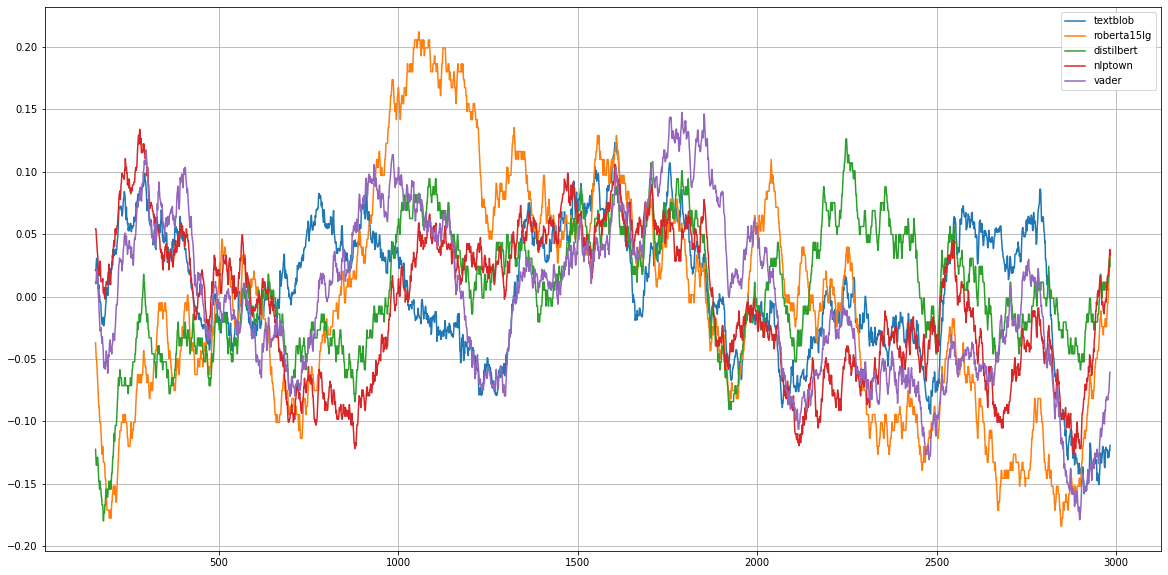

In [187]:
# Verify

_ = sentiment_all_sma_df[col_models_ls].plot(grid=True)

## Peak Detection

In [188]:
from scipy.signal import find_peaks

In [189]:
import warnings
warnings.filterwarnings('ignore')

In [190]:
# Which cols hold Model Sentiment Timeseries

col_nonmodels_ls = ['line_no','text_raw','text_clean']
col_models_ls = list(set(sentiment_all_sma_df.columns.to_list()) - set(col_nonmodels_ls))
col_models_ls

['textblob', 'roberta15lg', 'distilbert', 'nlptown', 'vader']

In [191]:
#@title Which Lexicon?

Sentiment_Model = "vader" #@param ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']

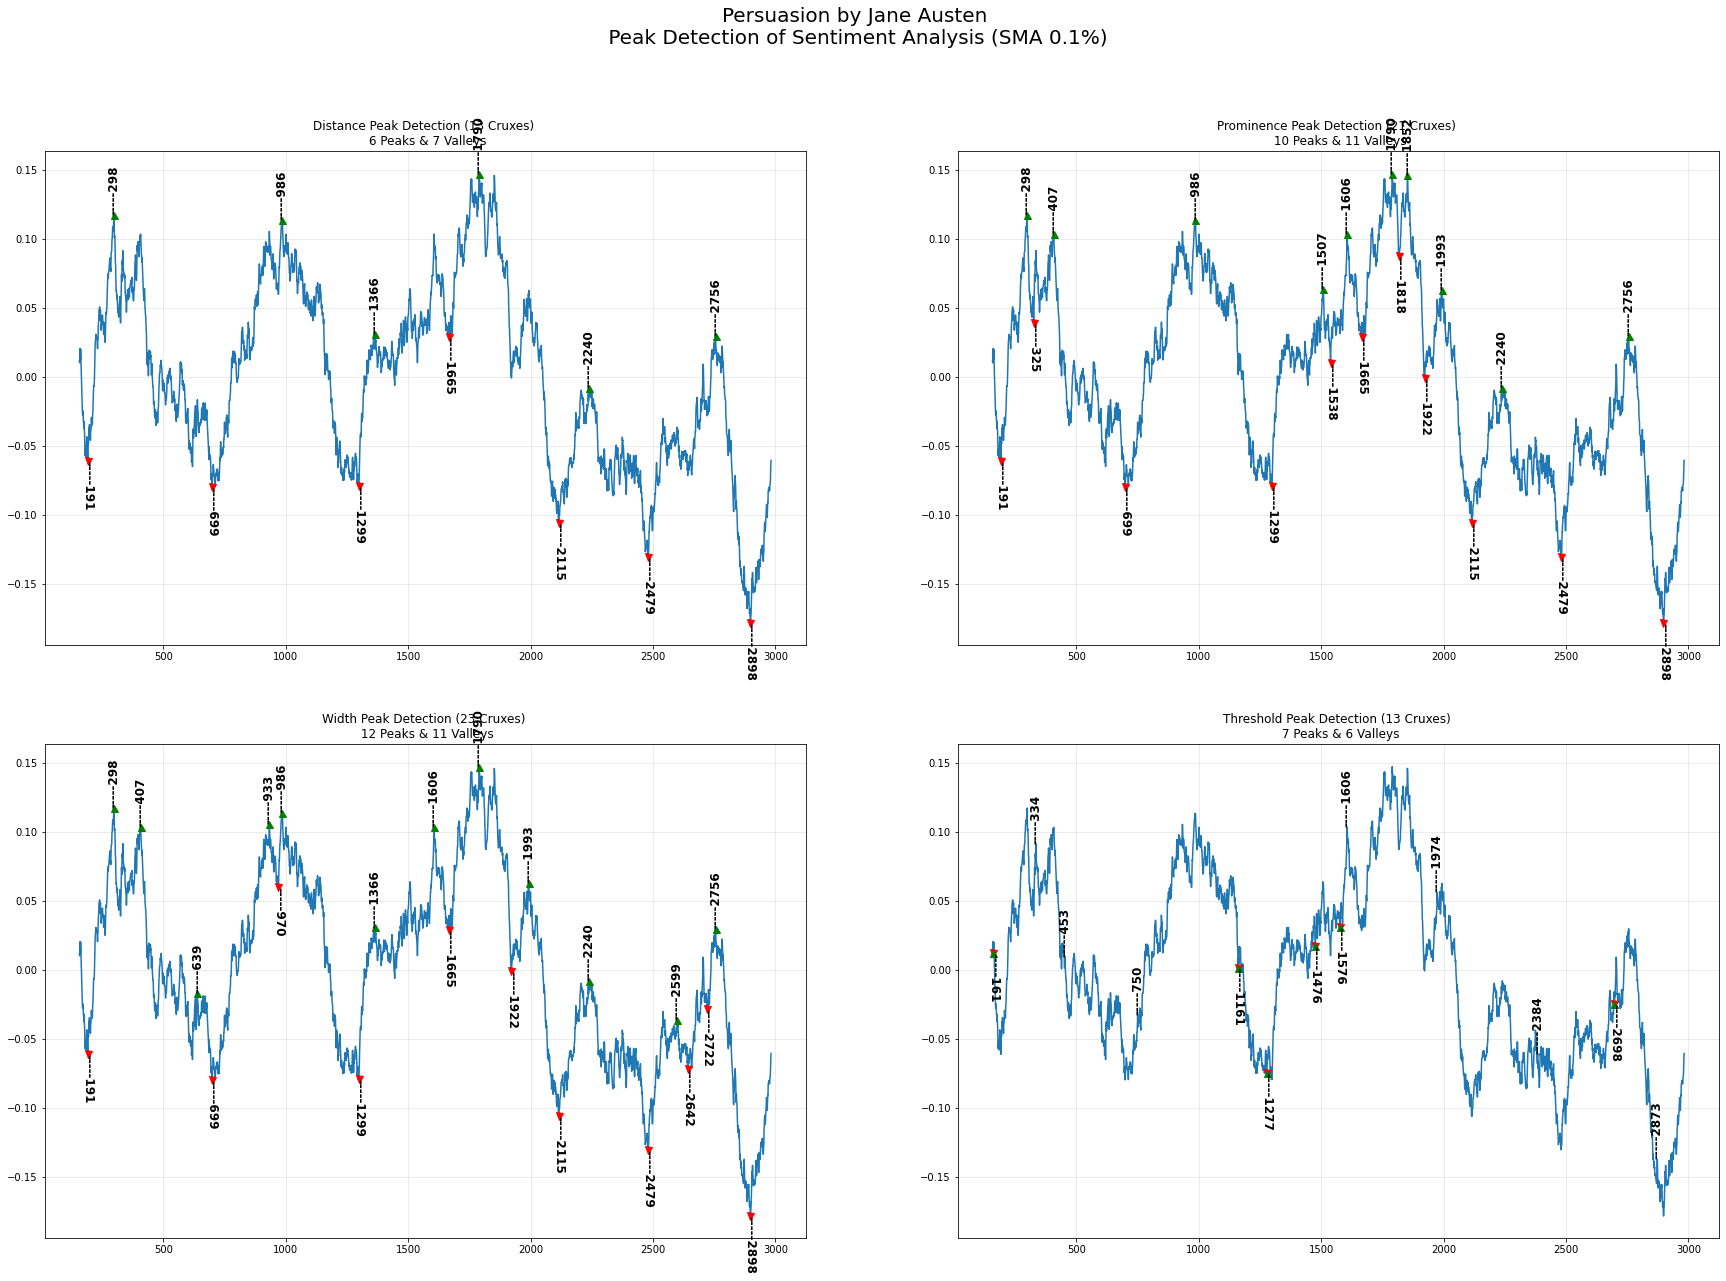

In [192]:
#@title Tune the main Hyperparameter for each of the 4 Peak Detection Algorithms:

Distance_Min = 360 #@param {type:"slider", min:100, max:1000, step:10}
Prominence_Min = 0.05 #@param {type:"slider", min:0.01, max:0.1, step:0.01}
Width_Min = 25 #@param {type:"slider", min:25, max:500, step:5}
Threshold_Min = 0.007 #@param {type:"slider", min:0.001, max:0.01, step:0.001}

plt.rcParams['figure.figsize'] = [30, 20]

# model_name = f'{Sentiment_Model.lower()}_sma{int(win_per)}'
model_name = Sentiment_Model.lower().strip()

x = sentiment_all_sma_df[model_name]

# Peak Algo #1 (by Distance)
distance_min = Distance_Min # 750

# Peak Algo #2 (by Prominence)
prominence_min = Prominence_Min # 0.01

# Peak Algo #3 (by Width)
width_min = Width_Min # 175

# Peak Algo #4 (by Threshold)
threshold_min = Threshold_Min # 0.001


peaks, _ = find_peaks(x, distance=distance_min)
peaks2, _ = find_peaks(x, prominence=prominence_min)      # BEST!
peaks3, _ = find_peaks(x, width=width_min)
peaks4, _ = find_peaks(x, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


x_inv = pd.Series([-x for x in sentiment_all_sma_df[model_name].to_list()])

valleys, _ = find_peaks(x_inv, distance=distance_min)
valleys2, _ = find_peaks(x_inv, prominence=prominence_min)      # BEST!
valleys3, _ = find_peaks(x_inv, width=width_min)
valleys4, _ = find_peaks(x_inv, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless

_ = plt.subplot(2, 2, 1)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Distance Peak Detection ({len(peaks)+len(valleys)} Cruxes) \n {len(peaks)} Peaks & {len(valleys)} Valleys')
_ = plt.plot(peaks, x[peaks], "^g", markersize=7)
_ = plt.plot(valleys, x[valleys], "vr", markersize=7)
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.subplot(2, 2, 2)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Prominence Peak Detection ({len(peaks2)+len(valleys2)} Cruxes) \n {len(peaks2)} Peaks & {len(valleys2)} Valleys')
_ = plt.plot(peaks2, x[peaks2], "^g", markersize=7)
_ = plt.plot(valleys2, x[valleys2], "vr", markersize=7)
for x_val in peaks2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 3)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Width Peak Detection ({len(peaks3)+len(valleys3)} Cruxes) \n {len(peaks3)} Peaks & {len(valleys3)} Valleys')
_ = plt.plot(valleys3, x[valleys3], "vr", markersize=7)
_ = plt.plot(peaks3, x[peaks3], "^g", markersize=7)
for x_val in peaks3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 4)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Threshold Peak Detection ({len(peaks4)+len(valleys4)} Cruxes) \n {len(peaks4)} Peaks & {len(valleys4)} Valleys')
_ = plt.plot(valleys4, x[valleys4], "vr", markersize=7)
_ = plt.plot(valleys4, x[valleys4], "^g", markersize=7)
for x_val in peaks4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.suptitle(f'{novel_title_str}\n Peak Detection of Sentiment Analysis (SMA {win_per}%)', fontsize=20)
_ = plt.grid(True, alpha=0.3)

_ = plt.show();

plt.rcParams['figure.figsize'] = [12,8]

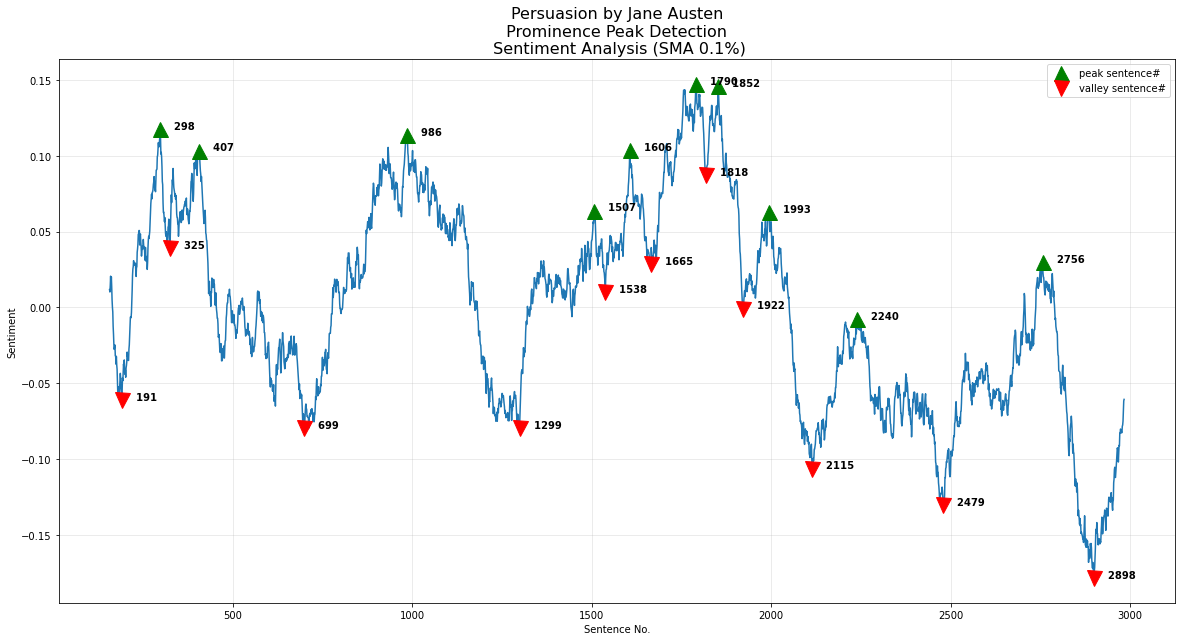



     >>>>> SAVED PLOT TO FILE: [cruxes_plot_Persuasion_by_Jane_Austen.png] <<<<<


In [193]:
#@title Select a Peak Detection Algorithms to View in Detail (usually Distance or Width is best):

plt.rcParams['figure.figsize'] = [20, 10]

Peak_Algorithm = "Prominence" #@param ["Distance", "Prominence", "Width", "Threshold"]

if Peak_Algorithm == 'Distance':
  peaks = peaks
  valleys = valleys
elif Peak_Algorithm == 'Prominence':
  peaks = peaks2
  valleys = valleys2  
elif Peak_Algorithm == 'Width':
  peaks = peaks3
  valleys = valleys3
else:
  # Assume Peak_Algorithm == 'Threshold'
  peaks = peaks4
  valleys = valleys4

# model_name = f'{Sentiment_Model.lower()}_sma10'

# x = novel_clean_df[model_name]

# peaks2, _ = find_peaks(x, prominence=peak_prominence)  

# x_inv = pd.Series([-x for x in novel_clean_df[model_name].to_list()])
# valleys2, _ = find_peaks(x_inv, prominence=peak_prominence)     

_ = plt.plot(x)
_ = plt.plot(peaks, x[peaks], "^g", markersize=15, label='peak sentence#')
_ = plt.plot(valleys, x[valleys], "vr", markersize=15, label='valley sentence#')
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
_ = plt.title(f'{Novel_Title}\n {Peak_Algorithm} Peak Detection \n Sentiment Analysis (SMA {win_per}%)', fontsize=16)
_ = plt.ylabel('Sentiment')
_ = plt.xlabel('Sentence No.')
_ = plt.legend(loc='best')
_ = plt.grid(True, alpha=0.3)

filename_plot = f"cruxes_plot_{Novel_Title.replace(' ', '_')}.png"
_ = plt.savefig(filename_plot, dpi=300)
_ = plt.show();

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_plot}] <<<<<')

In [194]:
# Download Crux Point Plot file 'crux_plot.png' to your laptop

files.download(filename_plot)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Crux Extraction

In [195]:
#@title How many Sentences around Crux Point do you want to view for context?

Crux_Sentence_Context_Count = 15 #@param {type:"slider", min:1, max:20, step:1}


**[NOTE]** May have to run next code cell **2-3x times** to save file
<br><br>
ERROR **'cap is not defined'** may appear (just rerun code cell)

In [196]:
%%capture cap --no-stderr

# Print Context around each Sentiment Peak

halfwin = int(Crux_Sentence_Context_Count/2)
crux_sents_ls = []
nl = '\n'

print('==================================================')
print('============     Peak Crux Points   ==============')
print('==================================================\n\n')

# for i, apeak in enumerate(peaks2):
for i, apeak in enumerate(peaks):
  crux_sents_ls = []
  for sent_idx in range(apeak-halfwin,apeak+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == apeak:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)
  
  # context_ls = sentiment_df.iloc[apeak-halfwin:apeak+halfwin].text_raw
  print(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

print('==================================================')
print('===========     Crux Valley Points    ============')
print('==================================================\n\n')


# for i, avalley in enumerate(valleys2):
for i, avalley in enumerate(valleys):
  crux_sents_ls = []
  for sent_idx in range(avalley-halfwin,avalley+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == avalley:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)

  # context_ls = novel_df.iloc[avalley-halfwin:avalley+halfwin].text_raw
  print(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

filename_cruxes = f"cruxes_context_{Novel_Title.replace(' ', '_')}.txt" 

with open(filename_cruxes, 'w') as f:
    f.write(str(cap))

In [197]:
# Download Crux Point Report file 'cruxes.txt' to your laptop

files.download(filename_cruxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [198]:
# Verify Crux Points

!cat $filename_cruxes

============     Peak Crux Points   ==============


Peak #0 at Sentence #259:

At the head of the column, beside
the red flag, Georges Kopp, the stout Belgian _commandante_, was riding a
black horse; a little way ahead a youth from the brigand-like militia
cavalry pranced to and fro, galloping up every piece of rising ground
and posing himself in picturesque attitudes at the summit.
The splendid
horses of the Spanish cavalry had been captured in large numbers during
the revolution and handed over to the militia, who, of course, were busy
riding them to death.
The road wound between yellow infertile fields, untouched since last
year's harvest.
Ahead of us was the low sierra that lies between
Alcubierre and Zaragoza.
We were getting near the front line now, near
the bombs, the machine-guns, and the mud.
In secret I was frightened.
I
knew the line was quiet at present, but unlike most of the men about me
I was old enough to remember the Great War, though not old enough to
have fought in 

# **END OF NOTEBOOK**